How to test for momentum change in NFL football using a ten year period of data from 2002 to 2012.

First, consolidate data from Advanced Football Analytics Play-By-Play Data by Brian Burke.

In the process of creating this dataframe, I added two columns in Access that would help out with the data crunching.  A) I added a column that simply provided the yards gained IF it was a third down, B) I added another column to immediately trigger "Succes" if there was either more yards gained than needed for the 3rd down OR a touchdown/field goal was made. In the later cases (although there are NOT many field goals attempted on 3rd down) the 3rd down was considered a success in my dataframe.

In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import requests
import csv

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


In [41]:
NFLDataFrame = pd.read_csv("../data/2002_2012_nfl_pbp_data.csv")
print NFLDataFrame.dtypes
print NFLDataFrame.head(32)
print NFLDataFrame.shape

gameid             object
qtr                 int64
min               float64
sec               float64
off                object
def                object
down              float64
togo              float64
ydline            float64
description        object
3rd Down Yards     object
Successful_3rd     object
offscore            int64
defscore            int64
season              int64
dtype: object
              gameid  qtr   min   sec  off  def  down  togo  ydline  \
0   20120905_DAL@NYG    1  51.0  43.0  NYG  DAL   2.0   8.0    29.0   
1   20120905_DAL@NYG    1  51.0  33.0  DAL  NYG   1.0  10.0    66.0   
2   20120905_DAL@NYG    1  50.0  54.0  DAL  NYG   2.0   8.0    64.0   
3   20120905_DAL@NYG    1  50.0  39.0  DAL  NYG   2.0  13.0    69.0   
4   20120905_DAL@NYG    1  50.0   1.0  DAL  NYG   3.0   4.0    60.0   
5   20120905_DAL@NYG    1  49.0  26.0  DAL  NYG   1.0  10.0    46.0   
6   20120905_DAL@NYG    1  49.0   9.0  DAL  NYG   1.0  15.0    51.0   
7   20120905_DAL@NYG    1  4

In [42]:
NFL_DataFrame = NFLDataFrame.dropna()

In [43]:
GameCount = NFL_DataFrame.gameid.count()
print GameCount
#This is the amount of records in the DFrame now - without the BLANKS in the core csv file evidently.

389985


Now, I need to find out if the team won the game or lost the game.

In order to gather the data regarding succssessful 3rd down conversion, I will have to mask everything by the "Successful_3rd" column that I created in MicroSoft Access.

In [44]:
datamask = NFLDataFrame.Successful_3rd == "Success"

ONLY_SUCC = NFLDataFrame[datamask]
x = ONLY_SUCC.Successful_3rd.unique()
print x 
#ONLY_SUCC.head(15)


['Success']


In [45]:
ByQtr_success = ONLY_SUCC.groupby(["gameid","off","qtr"]).Successful_3rd.count()
#print ByQtr_success

This is nice, but notice how the columns (by quarter) above DO NOT tell me when there is a quarter that has NO 3rd down conversions - to get around this, I decided to use a Pivot table, later on I will find out that there were actually teams that had no 3rd down conversions the entire game.

But we will see what happens when we merge this data with the other two features.

OK, I will need to incorporate a Pivot Table with the use of an unstack() flavor.  I went to the StackOverflow website and asked the question AFTER creating an account. MLybeer **** BeastMode@24 **** everything is attached to my Gmail account. . . mlybeer1@gmail.com

In [46]:
QUARTER_FRAME = ONLY_SUCC.pivot_table(index=['gameid','off']
                            ,columns=['qtr']
                            ,values=['Successful_3rd']
                            ,fill_value=0
                            ,aggfunc='count').rename(columns={1:'First',2:'Second',3:'Third',4:'Fourth',5:'Overtime'})           
                            
print QUARTER_FRAME                           
QUARTER_FRAME.describe()

                     Successful_3rd                             
qtr                           First Second Third Fourth Overtime
gameid           off                                            
20020905_SF@NYG  NYG              1      4     1      4        0
                 SF               1      2     1      0        0
20020908_ARI@WAS ARI              2      1     2      0        0
                 WAS              3      2     1      2        0
20020908_ATL@GB  ATL              0      1     3      1        0
                 GB               2      4     1      0        0
20020908_BAL@CAR BAL              1      1     2      2        0
                 CAR              3      3     0      2        0
20020908_DAL@HOU DAL              0      1     1      0        0
                 HOU              1      0     1      1        0
20020908_DET@MIA DET              1      2     2      3        0
                 MIA              1      2     1      1        0
20020908_IND@JAC IND     

Successful_3rd                                                    
qtr            First       Second        Third       Fourth     Overtime
count    5252.000000  5252.000000  5252.000000  5252.000000  5252.000000
mean        1.260091     1.514661     1.272087     1.376428     0.043793
std         1.088252     1.193829     1.107289     1.140718     0.271803
min         0.000000     0.000000     0.000000     0.000000     0.000000
25%         0.000000     1.000000     0.000000     1.000000     0.000000
50%         1.000000     1.000000     1.000000     1.000000     0.000000
75%         2.000000     2.000000     2.000000     2.000000     0.000000
max         7.000000     7.000000     7.000000     6.000000     3.000000

In [47]:
Game_abs_value = QUARTER_FRAME["Successful_3rd"].Fourth + QUARTER_FRAME["Successful_3rd"].Third + QUARTER_FRAME["Successful_3rd"].Second + QUARTER_FRAME["Successful_3rd"].First
Game_total_delta = (QUARTER_FRAME["Successful_3rd"].Fourth + QUARTER_FRAME["Successful_3rd"].Third) - (QUARTER_FRAME["Successful_3rd"].Second + QUARTER_FRAME["Successful_3rd"].First) 
Game_coeff = (Game_total_delta / Game_abs_value) * 0.5
                
#print Game_coeff


In [48]:
First_abs_value = QUARTER_FRAME["Successful_3rd"].Second + QUARTER_FRAME["Successful_3rd"].First
First_total_delta = (QUARTER_FRAME["Successful_3rd"].Second) - (QUARTER_FRAME["Successful_3rd"].First) 
First_coeff = (First_total_delta / First_abs_value) * 0.25
                
#print First_coeff

In [49]:
Second_abs_value = QUARTER_FRAME["Successful_3rd"].Third + QUARTER_FRAME["Successful_3rd"].Fourth
Second_total_delta = (QUARTER_FRAME["Successful_3rd"].Fourth) - (QUARTER_FRAME["Successful_3rd"].Third) 
Second_coeff = (Second_total_delta / Second_abs_value) * 0.25
                
#print Second_coeff

In [50]:
Final_3rd_score = Game_coeff + First_coeff + Second_coeff
print "Maximum Ranking", round(Final_3rd_score.max(),3)
print "Minimum Ranking", round(Final_3rd_score.min(),3)
print "Average Ranking", round(Final_3rd_score.mean(),3)
print "Std. Deviation Ranking", round(Final_3rd_score.std(),3)

Final_3rd_score.describe()
print Final_3rd_score

Maximum Ranking 0.833
Minimum Ranking -0.875
Average Ranking 0.02
Std. Deviation Ranking 0.297
gameid            off
20020905_SF@NYG   NYG    0.300000
                  SF    -0.416667
20020908_ARI@WAS  ARI   -0.433333
                  WAS   -0.091667
20020908_ATL@GB   ATL    0.425000
                  GB    -0.523810
20020908_BAL@CAR  BAL    0.166667
                  CAR    0.000000
20020908_DAL@HOU  DAL    0.000000
                  HOU   -0.083333
20020908_DET@MIA  DET    0.258333
                  MIA   -0.016667
20020908_IND@JAC  IND   -0.200000
                  JAC   -0.091667
20020908_KC@CLE   CLE   -0.083333
                  KC    -0.690476
20020908_MIN@CHI  CHI    0.166667
                  MIN   -0.113095
20020908_NO@TB    NO    -0.500000
                  TB     0.833333
20020908_NYJ@BUF  BUF    0.083333
                  NYJ   -0.166667
20020908_PHI@TEN  PHI    0.321429
                  TEN    0.083333
20020908_SD@CIN   CIN    0.633333
                  SD    -0.166667

Great!  Now, let's also calculate a 'percent differential' of the total sum of offensive plays.  I originally planned on correlating the 'percent differenctial' on time-of-possesion, but on further assessment I believe that the total sum of offensive plays may actually be a better gauge for measuring the who has the kinetic possesion of the ball more (as opposed to the potential possesion represented by the clock).

I think some simple Groupbys will work best for this section... let's see.

In [51]:
Possesion = (NFLDataFrame.groupby(["gameid","off"]).off.count() / NFLDataFrame.groupby(["gameid"]).off.count()) * 100
#print Possesion

Actually, I'm pretty sure that the Win_Loss groupby and the Possesion groupbys can by combined in the same general aggregate view.

In [72]:
g = NFLDataFrame.groupby(["gameid","off"])
##
v = np.where((g.offscore.max() - g.defscore.max()) > 0, 1, 0)
p = ((NFLDataFrame.groupby(["gameid","off"]).off.count() / NFLDataFrame.groupby(["gameid"]).off.count()) * 100).round(1)
opp_p = 100 - p
diff = p - opp_p


 
# Now, lets scale this from 1 to -1 
scaler = MinMaxScaler(feature_range=(-1,1))
##---------------------------
df = pd.DataFrame({'Win_Loss' : v, 'Possesion %' : diff, 'TDC_Rank' : Final_3rd_score})



In [73]:
df.dtypes

Possesion %    float64
TDC_Rank       float64
Win_Loss         int32
dtype: object

In [74]:
df.shape

(5818, 3)

In [75]:
DF_ = df.fillna({'TDC_Rank' : 0.0}, inplace=True)
#print DF_


In [76]:
## center and scale the data
scaler = StandardScaler()
ALL_feature_cols = ['TDC_Rank','Possesion %']
df_scaled = scaler.fit_transform(df[ALL_feature_cols])
df_scaled = pd.DataFrame(df_scaled,columns=ALL_feature_cols)
print "Before scaling:\n", df[ALL_feature_cols].describe()
print "\nAfter scaling:\n", np.round(df_scaled.describe(),2)

Before scaling:
          TDC_Rank  Possesion %
count  5818.000000  5818.000000
mean      0.016330     0.000034
std       0.265572    10.617802
min      -0.875000   -39.200000
25%      -0.095400    -7.000000
50%       0.000000     0.000000
75%       0.166667     7.000000
max       0.833333    39.200000

After scaling:
       TDC_Rank  Possesion %
count   5818.00      5818.00
mean       0.00         0.00
std        1.00         1.00
min       -3.36        -3.69
25%       -0.42        -0.66
50%       -0.06         0.00
75%        0.57         0.66
max        3.08         3.69


Great!  I have my scaled dataset.  Now I have to goback and use 0 and 1 for a Loss or a Win --

In [77]:
logreg = LogisticRegression(C=1e9)
feature_col_1 = ['TDC_Rank']
feature_col_2 = ['Possesion %']
ALL_feature_cols = ['TDC_Rank','Possesion %']
X = df[feature_col_1]
y = df.Win_Loss
logreg.fit(X, y)
outcome_pred_class_log = logreg.predict(X)

In [80]:
# sort DataFrame by Third-Down Conversions so that the line plot makes sense
df.sort_values('TDC_Rank', inplace=True)

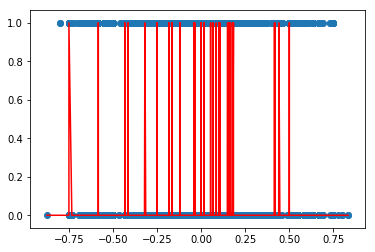

In [81]:
# plot the Win_Loss class predictions
plt.scatter(df.TDC_Rank, df.Win_Loss)
plt.plot(df.TDC_Rank, outcome_pred_class_log, color='red')

In [86]:
df[-110:]

,,Possesion %,TDC_Rank,Win_Loss
gameid,off,,,
20121126_CAR@PHI,CAR,14.0,0.633333,1
20071118_CHI@SEA,CHI,-2.2,0.633333,0
20041010_MIN@HOU,HOU,-10.6,0.633333,1
20031005_MIA@NYG,MIA,-3.2,0.633333,1
20031012_CHI@NO,CHI,-7.2,0.633333,0
20021007_GB@CHI,CHI,-0.6,0.633333,0
20080921_CAR@MIN,MIN,9.6,0.633333,1
20100912_CIN@NE,CIN,7.6,0.633333,0
20101219_NYJ@PIT,NYJ,-11.2,0.633333,1
